In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pyntcloud import PyntCloud
import plyfile as ply
import sys

In [2]:
import DracoPy

In [69]:
import open3d as o3d
from tqdm import tqdm

def combine (
    main_dir, 
    Nfiles=100,
    outdir='dataset_final',
    ):
    import glob 
    # find all scan codes
    left_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_LEFT', '*.ply'))
    left_lidar_codes = [f.split('/')[-1].split('.')[0] for f in left_lidar_codes]
    left_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    right_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_RIGHT', '*.ply'))
    right_lidar_codes = [f.split('/')[-1].split('.')[0] for f in right_lidar_codes]
    right_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    top_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_TOP', '*.ply'))
    top_lidar_codes = [f.split('/')[-1].split('.')[0] for f in top_lidar_codes]
    top_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    # find intersection of scan code
    print ("Finding intersection of scan codes")
    scan_codes = set(left_lidar_codes).intersection(set(right_lidar_codes)).intersection(set(top_lidar_codes))
    scan_codes = list(scan_codes)
    scan_codes.sort()
    scan_codes = scan_codes[:Nfiles]
    print (f"Number of scan codes: {len(scan_codes)}")


    # combine lidar data
    all_lidars = ['LIDAR_FRONT_LEFT', 'LIDAR_FRONT_RIGHT', 'LIDAR_TOP']
    outdir = os.path.join(main_dir, outdir)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # save combined point clouds and labels
    for code in tqdm(scan_codes):
        pcd_combined = o3d.geometry.PointCloud() 
        labels = []
        for lidar in all_lidars:
            file = os.path.join(main_dir, lidar,  code + '.ply')
            # load labels, i.e the  PlyProperty('ObjTag', 'uchar')), fourth property of the ply file
            plydata = ply.PlyData.read(file)
            labels += list(np.array(plydata.elements[0].data['ObjTag']))
            
            # load point clouds
            pc = o3d.io.read_point_cloud(file, format='ply')
            pcd_combined += pc

        

        # get labels
        labels = np.array(labels)
        #save labels
        # np.save(os.path.join(outdir, code + '_labels.npy'), labels)
        o3d.io.write_point_cloud(os.path.join(outdir, code + '.ply'), pcd_combined)

        # read again the file with plyfile and add the labels as a property
        plydata = ply.PlyData.read(os.path.join(outdir, code + '.ply'))

        # add the labels as a property
        x, y, z = plydata.elements[0].data['x'], plydata.elements[0].data['y'], plydata.elements[0].data['z']
        element = ply.PlyElement.describe(np.array(list(zip(x, y, z, labels)), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('ObjTag', 'u1')]), 'vertex')
        plydata.elements = [element]
        plydata.write(os.path.join(outdir, code + '.ply'))
        

In [70]:
#  create the final dataset 

main_dir = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset'
combine(main_dir, Nfiles=100, outdir='dataset_final')



Number of left lidar codes: 1634
Number of left lidar codes: 1634
Number of left lidar codes: 1634
Finding intersection of scan codes
Number of scan codes: 100


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


In [72]:
# test 
file = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset/dataset_final/Town01_Opt_ClearSunset_149552537472963948.ply'
file = ply.PlyData.read(file)
file.elements[0].data

memmap([(13.939179 , 1.3939118e+01,  3.4759111, 0),
        (13.976289 , 1.4060769e+01,  3.4957232, 0),
        (14.013828 , 1.4183835e+01,  3.5157988, 0), ...,
        (-2.7477734, 3.3139646e-02, -1.5865506, 8),
        (-2.7478905, 2.2094727e-02, -1.5865506, 8),
        (-2.7479687, 1.1049804e-02, -1.5865506, 8)],
       dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('ObjTag', 'u1')])

In [6]:
import shutil
from glob import glob
import pandas as pd

Draco compression over the whole merged directory

In [13]:
import time
import plyfile

path_to_combined_data = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset/dataset_final'
all_pc = glob(os.path.join(path_to_combined_data, '*.ply'))


draco_unlabeled = pd.DataFrame(columns=['filename', 'original_size', 'original_size_bytes', 
                                        'encoded_size', 'encoded_size_bytes', 
                                        'compression_ratio', 'compression_ratio_bytes', 
                                        'encoding_decoding_time', 'lost_points'])


TypeError: 'module' object is not callable

In [17]:

for pc in all_pc:

    # Start the timer
    start = time.time()

    # Read the ply file
    plydata = plyfile.PlyData.read(pc)
    # Extract the XYZ coordinates of the points
    points = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T

    # Measure the number of points in the original point cloud
    original_size = len(points)
    original_size_bytes = sys.getsizeof(points)

    # Encode the point cloud
    encoded_data = DracoPy.encode(points)

    # Measure the size of the encoded data
    encoded_size = len(encoded_data)
    encoded_size_bytes = sys.getsizeof(encoded_data)


    # Decode the encoded data
    decoded_points = DracoPy.decode(encoded_data)
    # End the timer
    end = time.time()

    # fiond nearest points to the decoded points in the original point cloud
    lost_points = len(points) - len(decoded_points.points)

    # print("Mean Point Distance Error: {:.2f} m".format(mpde))
    # Calculate the compression ratio
    encoded_compression_ratio = 1 - (encoded_size_bytes / original_size_bytes)

    # print("Compression ratio (encoded): {:.2f} % ".format(encoded_compression_ratio * 100))

    # Print the total time taken
    # print("Time taken for all point clouds: {:.2f} seconds".format(end - start))

    # Save the results
    draco_unlabeled = draco_unlabeled.append({'filename': pc, 
                                            'original_size': original_size, 
                                            'original_size_bytes': original_size_bytes, 
                                            'encoded_size': encoded_size, 
                                            'encoded_size_bytes': encoded_size_bytes, 
                                            'compression_ratio': encoded_compression_ratio, 
                                            'compression_ratio_bytes': encoded_compression_ratio, 
                                            'encoding_decoding_time': end - start, 
                                            'lost_points': lost_points,
                                            }, 
                                            ignore_index=True)


KeyboardInterrupt: 

In [104]:
# plot some results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.5)

# aggregate the results
stats = pd.DataFrame(columns=draco_unlabeled.columns)
stats.loc['avg'] = draco_unlabeled.mean()
stats.loc['std'] = draco_unlabeled.std()

print (f" Average compression ratio: {stats.loc['avg', 'compression_ratio'] * 100:.2f} % pm {stats.loc['std', 'compression_ratio'] * 100:.2f} %")
print (f" Average compression ratio (bytes): {stats.loc['avg', 'compression_ratio_bytes'] * 100:.2f} % pm {stats.loc['std', 'compression_ratio_bytes'] * 100:.2f} %")
print (f" Average encoding-decoding time: {stats.loc['avg', 'encoding_decoding_time']:.2f} seconds pm {stats.loc['std', 'encoding_decoding_time']:.2f} seconds")
print (f" Average lost points: {stats.loc['avg', 'lost_points']:.2f} points pm {stats.loc['std', 'lost_points']:.2f} points")


 Average compression ratio: 91.07 % pm 0.47 %
 Average compression ratio (bytes): 91.07 % pm 0.47 %
 Average encoding-decoding time: 0.41 seconds pm 0.06 seconds
 Average lost points: 1836.16 points pm 1584.36 points


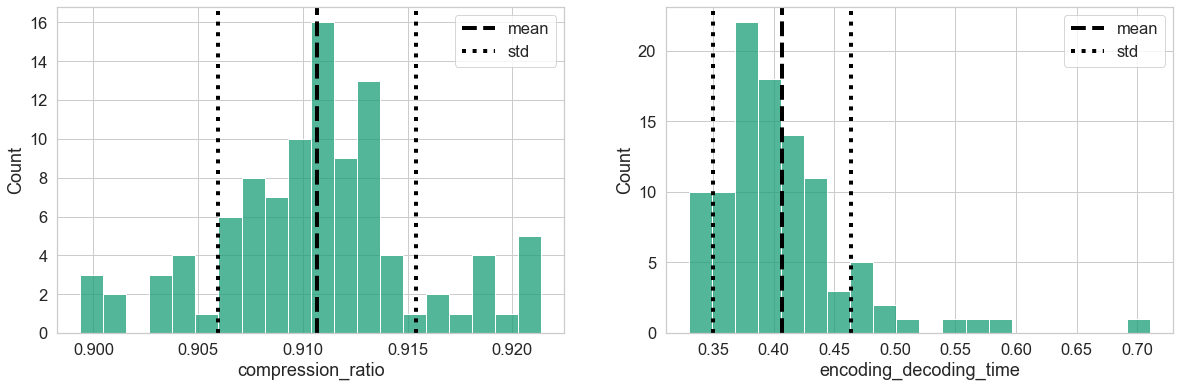

In [111]:
# plot 
sns.set_theme(style='whitegrid', font_scale=1.5, palette='Dark2')
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=draco_unlabeled, x='compression_ratio', ax=ax[0], bins=20)
sns.histplot(data=draco_unlabeled, x='encoding_decoding_time', ax=ax[1], bins=20) 

# add mean and std
lw = 4
ax[0].axvline(stats.loc['avg', 'compression_ratio'], color='black', linestyle='--', label='mean', linewidth=lw)
ax[0].axvline(stats.loc['avg', 'compression_ratio'] + stats.loc['std', 'compression_ratio'], color='black', linestyle=':', label='std', linewidth=lw)
ax[0].axvline(stats.loc['avg', 'compression_ratio'] - stats.loc['std', 'compression_ratio'], color='black', linestyle=':', linewidth=lw)
ax[0].legend()

ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'], color='black', linestyle='--', label='mean', linewidth=lw)
ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'] + stats.loc['std', 'encoding_decoding_time'], color='black', linestyle=':', label='std', linewidth=lw)
ax[1].axvline(stats.loc['avg', 'encoding_decoding_time'] - stats.loc['std', 'encoding_decoding_time'], color='black', linestyle=':', linewidth=lw)
ax[1].legend()



Remove header and metadata

In [46]:
def draco_labeled (pc_file):
    # Read the ply file
    plydata = plyfile.PlyData.read(pc_file)

    # Extract the XYZ coordinates of the points
    points = np.column_stack((plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']))
    # Extract the labels of the points
    labels = plydata['vertex']['ObjTag']
    print (f"Number of labels: {len(np.unique(labels))}")

    # iterate over the labels and encode each label separately

    results_PC = pd.DataFrame(columns=['label', 'original_size', 'original_size_bytes', 'encoded_size', 
                                        'encoded_size_bytes', 'compression_ratio', 'compression_ratio_bytes', 
                                        'encoding_decoding_time', 'lost_points']) 

    for label in np.unique(labels):
        start = time.time()
        mask = labels == label

        pc_label = points[mask]
        # print (f"Number of points in label {label}: {len(pc_label)}") 

        # Encode the point cloud
        encoded_data = DracoPy.encode(pc_label)

        # Measure the size of the encoded data
        encoded_size = len(encoded_data)
        encoded_size_bytes = sys.getsizeof(encoded_data)


        # Measure the number of points in the original point cloud
        original_size = len(points)
        original_size_bytes = sys.getsizeof(points)

        # Decode the encoded data
        decoded_points = DracoPy.decode(encoded_data)
        # End the timer
        end = time.time()

        # Calculate the compression ratio
        compression_ratio = 1 - (encoded_size / original_size)
        compression_ratio_bytes = 1 - (encoded_size_bytes / original_size_bytes)

        # Calculate the number of lost points
        lost_points = len(points) - len(decoded_points.points)
        results_PC = results_PC.append({'label': label,     
                                        'original_size': original_size,         
                                        'original_size_bytes': original_size_bytes,
                                        'encoded_size': encoded_size,
                                        'encoded_size_bytes': encoded_size_bytes,
                                        'compression_ratio': compression_ratio,
                                        'compression_ratio_bytes': compression_ratio_bytes,
                                        'encoding_decoding_time': end - start,
                                        'lost_points': lost_points,
                                        },
                                        ignore_index=True)

    # save the results
    img_name = pc_file.split('/')[-1].split('.')[0]
    res_dir = 'results'
    
    results_PC.to_csv(os.path.join(res_dir, img_name+'draco_labeled.csv'), index=False)

    return results_PC
        

In [ ]:
# go through all the files and save the results
draco_labeled_res = dict()
for file in all_pc:
    draco_labeled_res[file] = draco_labeled(file)

Number of labels: 20
Number of points in label 0: 529
Number of points in label 1: 28256
Number of points in label 2: 10418
Number of points in label 5: 2187
Number of points in label 7: 99118
Number of points in label 8: 54167
Number of points in label 9: 14048
Number of points in label 10: 46884
Number of points in label 11: 278
Number of points in label 12: 29
Number of points in label 17: 37
Number of points in label 18: 21
Number of points in label 19: 7988
Number of points in label 20: 20
Number of points in label 40: 4574
Number of points in label 41: 693
Number of points in label 100: 373
Number of points in label 101: 37
Number of points in label 104: 1429
Number of points in label 105: 11
Number of labels: 18
Number of points in label 0: 42
Number of points in label 1: 44611
Number of points in label 2: 599
Number of points in label 5: 918
Number of points in label 7: 90241
Number of points in label 8: 58270
Number of points in label 9: 360
Number of points in label 10: 46885

KeyboardInterrupt: 

Draco compression over each single class

In [15]:
# Start the timer
start = time.time()

compressed_clouds = {}

# Read the ply file
plydata = plyfile.PlyData.read(merged_file)
# Extract the XYZ coordinates of the points
points = np.column_stack((plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']))
# Extract the labels of the points
labels = plydata['vertex']['ObjTag']

# Initialize variables to keep track of the total MPDE, compression ratio and the number of classes processed
total_mpde = 0
total_compression_ratio = 0
num_classes = 0


for label in np.unique(labels):
    start_class = time.time()
    # Get the points with the current label
    points_label = points[labels == int(label)]
    # Encode the point cloud
    encoded_data = DracoPy.encode(points_label)
    # Measure the size of the encoded data
    encoded_size = len(encoded_data)
    # Measure the size of the original data
    original_size = len(points_label)
    # Calculate the compression ratio
    compression_ratio = original_size/encoded_size
    print(f"Compression ratio for class {label}: {compression_ratio}")
    # Add the current compression ratio to the total compression ratio
    total_compression_ratio += compression_ratio
    # Decode the encoded data
    decoded_points = DracoPy.decode(encoded_data)
    # Calculate the mean point distance error
    mpde = np.mean(np.linalg.norm(points_label - decoded_points.points, axis=1))
    print(f"Mean Point Distance Error: {mpde}")
    # Add the current MPDE to the total MPDE
    total_mpde += mpde
    # Increase the number of classes processed
    num_classes += 1
    end_class = time.time()
    print("Time taken for class {}: {:.2f} seconds".format(label, end_class - start_class))

# End the timer
end = time.time()

# Print the total time taken
print("Time taken for all point clouds: {:.2f} seconds".format(end - start))

# Compute the mean MPDE and compression ratio
mean_mpde = total_mpde / num_classes
print("Mean MPDE: {:.2f}".format(mean_mpde))

mean_compression_ratio = total_compression_ratio / num_classes
print("Mean Compression Ratio: {:.2f}".format(mean_compression_ratio))

Compression ratio for class 0: 0.47106197106197106
Mean Point Distance Error: 22.100370053042777
Time taken for class 0: 0.01 seconds
Compression ratio for class 1: 0.28135313531353134
Mean Point Distance Error: 30.391186123269378
Time taken for class 1: 0.00 seconds
Compression ratio for class 2: 0.31684491978609625
Mean Point Distance Error: 31.079287671962618
Time taken for class 2: 0.00 seconds
Compression ratio for class 5: 0.3018292682926829
Mean Point Distance Error: 28.57726350301676
Time taken for class 5: 0.00 seconds
Compression ratio for class 7: 0.7988990949615021
Mean Point Distance Error: 3.4598004459592757
Time taken for class 7: 0.07 seconds
Compression ratio for class 8: 0.4733169129720854
Mean Point Distance Error: 7.43806509080998
Time taken for class 8: 0.01 seconds
Compression ratio for class 9: 0.3524975272007913
Mean Point Distance Error: 46.620560090005775
Time taken for class 9: 0.01 seconds
Compression ratio for class 10: 0.6334261209750226
Mean Point Distanc